# Finding Images with Words

Image classification and sentiment analysis models can be highly effective, but may not be geared to your specific computer vision use case. With multi-modal deep learning models like [OpenAI’s CLIP model](https://openai.com/blog/clip/), you can embed textual data and images in the same latent space, allowing you to search for images that most closely resemble an input text prompt. Leveraging a scalable vector search engine like [Pinecone](https://www.pinecone.io/), it is now possible to "semantically search" image datasets with natural language queries!

In this tutorial, you'll learn how to incorporate natural language image search directly into your computer vision workflows using FiftyOne. We'll also be using vector database Pinecone, and OpenAI’s CLIP model.

We'll cover the following topics:

* Loading in your data and embedding model
* Generating CLIP embeddings
* Creating a vector index
* Querying your vector index with text prompts
* What you can use this for

**So, what's the takeaway?**

FiftyOne can help you integrate semantic search queries into unstructured exploration, prototyping, and model evaluation workflows to improve the quality of your computer vision datasets and models!

## Setup

If you haven't already, install FiftyOne:

In [4]:
!pip install fiftyone

We'll also need `torch` and `torchvision` installed:

In [ ]:
!pip install torch torchvision

Lastly, we'll need to install Pinecone:

In [6]:
!pip install -U pinecone-client

Once FiftyOne is installed, we are good to go, and we can import the library. We’ll also import the `fiftyone.zoo` submodule so we can quickly load in a subset of the [MS COCO dataset](https://voxel51.com/docs/fiftyone/integrations/coco.html) from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html), as well as a PyTorch implementation of the CLIP model from the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html):

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation")
model = foz.load_zoo_model("clip-vit-base32-torch")

Found annotations at '/Users/jacobmarks/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


If you’d like, you can instead download OpenAI’s CLIP model directly from source by following instructions [here](https://github.com/openai/CLIP).

Before setting up Pinecone, we can take a look at our data in the FiftyOne App, which you can instantiate in your browser, within a Jupyter notebook, or as a standalone desktop application:


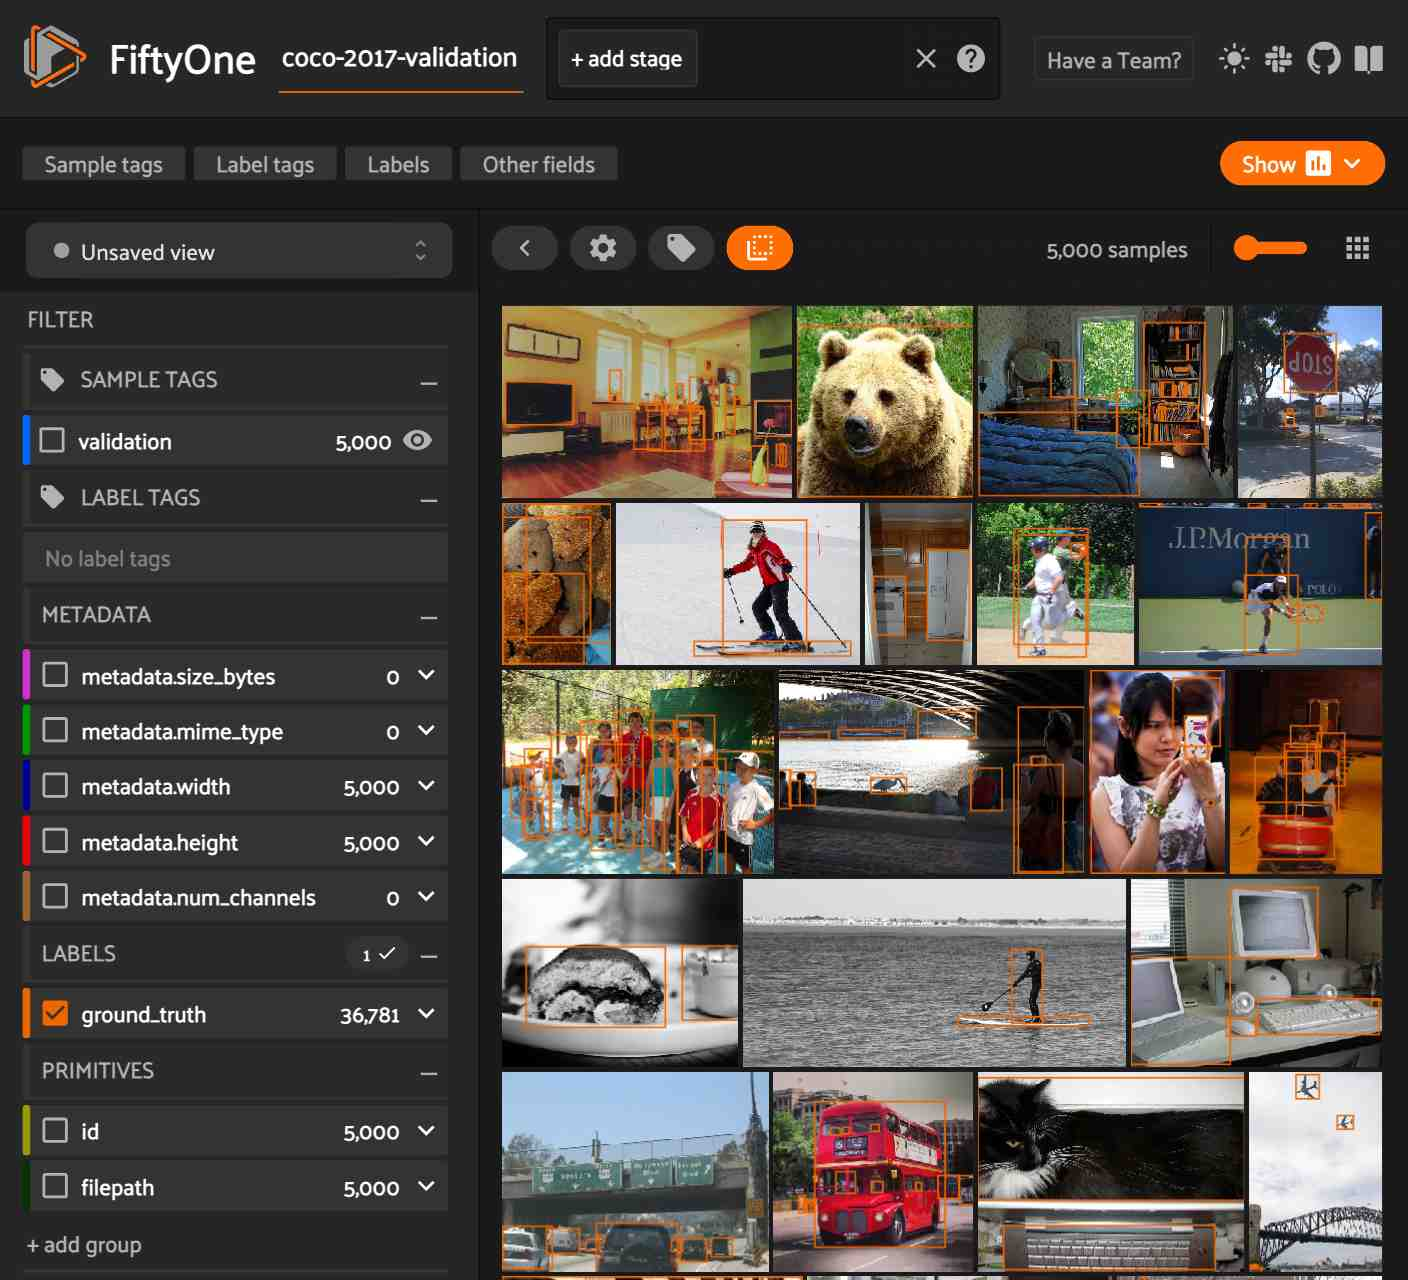

In [2]:
session = fo.launch_app(dataset)

To get started working with Pinecone, you need to set up an account [here](https://www.pinecone.io/), if you don’t have one already, and copy an API key from [here](https://app.pinecone.io/organizations). Import Pinecone and pass in an API key as follows:

In [4]:
import pinecone
pinecone.init(api_key="API-KEY", environment="us-west1-gcp")

And let's import the last few packages we'll need:

In [4]:
import numpy as np
from pkg_resources import packaging
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Generating CLIP embeddings

To perform semantic search, we need to generate embeddings for the images in our dataset, as well as any text prompts we might want to search against. 

With FiftyOne’s `compute_embeddings()` method, we can generate embeddings for all of the images in our dataset in one fell swoop, storing them in an `embedding` field:


In [5]:
dataset.compute_embeddings(
    model, 
    embeddings_field="embedding"
)

 100% |███████████████| 5000/5000 [3.4m elapsed, 0s remaining, 24.6 samples/s]      


This might take a few minutes, as computing embeddings from deep neural models is in general a relatively intensive task. If you plan to generate embeddings for many samples, best practice is to pre-compute them ahead of time, and if you intend to use these embeddings more than once, I suggest you persist this data by setting

In [6]:
dataset.persistent = True

If we’d like, we can also pair these embeddings with a dimensionality reduction technique to visualize the embeddings. Using the [FiftyOne Brain](https://voxel51.com/docs/fiftyone/user_guide/brain.html), we can do this with the `compute_visualization()` method:


In [23]:
import fiftyone.brain as fob
from fiftyone import ViewField as F

# perform dimensionality reduction using t-SNE
results = fob.compute_visualization(dataset, embeddings = "embedding", method = "tsne")

# visualize results, labeling by number of objects in image
results.visualize(labels=F("ground_truth.detections").length())

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.582s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.825662
[t-SNE] Computed conditional probabilities in 0.051s


/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] Iteration 50: error = 80.2364502, gradient norm = 0.0046372 (50 iterations in 0.683s)
[t-SNE] Iteration 100: error = 80.7005768, gradient norm = 0.0025561 (50 iterations in 0.518s)
[t-SNE] Iteration 150: error = 80.7050171, gradient norm = 0.0005539 (50 iterations in 0.484s)
[t-SNE] Iteration 200: error = 80.6982803, gradient norm = 0.0003416 (50 iterations in 0.557s)
[t-SNE] Iteration 250: error = 80.6925049, gradient norm = 0.0001926 (50 iterations in 0.546s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.692505
[t-SNE] Iteration 300: error = 2.1915989, gradient norm = 0.0011361 (50 iterations in 0.550s)
[t-SNE] Iteration 350: error = 1.8386334, gradient norm = 0.0004558 (50 iterations in 0.526s)
[t-SNE] Iteration 400: error = 1.6945410, gradient norm = 0.0002595 (50 iterations in 0.522s)
[t-SNE] Iteration 450: error = 1.6175762, gradient norm = 0.0001783 (50 iterations in 0.542s)
[t-SNE] Iteration 500: error = 1.5713907, gradient norm = 0.0001393 (50 

FigureWidget({
    'data': [{'customdata': array(['63c0a23794cacc387a94e160', '63c0a23794cacc387a94e174',
    …

Even in this very basic visualization, we can see that the images with tons of objects tend to cluster together. There’s much more that can be gleaned from visualizations like this, but that is not the focus of this article.

To compute the embedding for a text prompt, we need to first tokenize the text, then generate a feature vector for the input text which standardizes format, and finally encode this feature vector. The following function takes in a text prompt and the FiftyOne-wrapped PyTorch CLIP model we loaded, and performs the logic of generating the corresponding embedding vector:


In [8]:
if packaging.version.parse(
  torch.__version__
) < packaging.version.parse("1.8.0"):
  dtype = torch.long
else:
  dtype = torch.int

def get_text_embedding(prompt, clip_model):
    tokenizer = clip_model._tokenizer

    # standard start-of-text token
    sot_token = tokenizer.encoder["<|startoftext|>"]

    # standard end-of-text token
    eot_token = tokenizer.encoder["<|endoftext|>"]

    prompt_tokens = tokenizer.encode(prompt)
    all_tokens = [[sot_token] + prompt_tokens + [eot_token]]

    text_features = torch.zeros(
        len(all_tokens),
        clip_model.config.context_length,
        dtype=dtype,
        device=device,
    )

    # insert tokens into feature vector
    text_features[0, : len(all_tokens[0])] = torch.tensor(all_tokens)

    # encode text
    embedding = clip_model._model.encode_text(text_features).to(device)

    # convert to list for Pinecone
    return embedding.tolist()

To generate the embedding for the prompt “a picture of a giraffe”, we could do so with

In [9]:
prompt = "a picture of a giraffe"
query_vector = get_text_embedding(prompt, model)

## Creating the vector index

If you have a paid Pinecone account, then you can work with multiple *vector indices* at once. However, for this article we’ll be assuming only a free Pinecone account, which limits you to one vector index. In this case, you should run the following code block to delete any existing vector index associated with your account before creating a new one.

In [10]:
indices = pinecone.list_indexes()
if len(indices) > 0:
    pinecone.delete_index(indices[0])

After doing so, you can create a new vector index:

In [11]:
index_name = "my-index"
pinecone.create_index(index_name, dimension=512, metric="cosine", pod_type="p1")
index = pinecone.Index(index_name)

Here we have named the index “my-index” for illustrative purposes, but you can use whatever name you would like. We’ve passed in `dimension=512` because that is the dimension of the embedding vectors generated by CLIP, and we have chosen to use a “cosine” metric - vectors will be indexed according to their [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to the query vector. The `pod_type=”p1”` refers to the hardware running the Pinecone service; [p1 pods](https://docs.pinecone.io/docs/indexes#p1-pods) support up to one million vectors

Now we populate the vector database with the embedding vectors from our dataset, upserting $100$ vectors at a time:

In [13]:
# convert numpy arrays to lists for pinecone
embeddings = [arr.tolist() for arr in dataset.values("embedding")]
ids = dataset.values("id")

# create tuples of (id, embedding) for each sample
index_vectors = list(zip(ids, embeddings))

def upsert_vectors(index, vectors):
    num_vectors = len(vectors)
    num_vectors_per_step = 100
    num_steps = int(np.ceil(num_vectors/num_vectors_per_step))
    for i in range(num_steps):
        min_ind = num_vectors_per_step * i
        max_ind = min(num_vectors_per_step * (i+1), num_vectors)
        index.upsert(index_vectors[min_ind:max_ind])

upsert_vectors(index, index_vectors)

One subtle note is that we are using FiftyOne’s “id” value to identify these embedding vectors. We do this because all “id” identifiers are unique in FiftyOne, and we can index or subset the samples in our dataset by passing in a list of these “id” values, as we will do shortly.

## Querying the dataset

Now that we have a vector index and a function for computing the embedding vector for an input text prompt, we are ready to perform semantic search on our data.

To start, let’s say we want to find the $10$ gloomiest images. We can do this by first generating the query vector:

In [14]:
prompt = "a gloomy day"
query_vector = get_text_embedding(prompt, model)

Then querying our vector index for the $10$ most similar embedding vectors `top_k = 10` to this query vector:

In [15]:
top_k_samples = index.query(
    vector=query_vector,
    top_k=10,
    include_values=False
)['matches']

This returns a list of (ten) results, sorted by `score` on the cosine similarity metric.

In [16]:
top_k_samples

[{'id': '63c0a24094cacc387a95479d',
  'score': 0.28378427,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a24594cacc387a9583e4',
  'score': 0.275318384,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a24294cacc387a955e12',
  'score': 0.272279471,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a24094cacc387a954d7d',
  'score': 0.271256596,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a24394cacc387a956eaf',
  'score': 0.266826242,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a23a94cacc387a9509fd',
  'score': 0.264422953,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a24294cacc387a9563c4',
  'score': 0.263450027,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a23e94cacc387a953024',
  'score': 0.263155311,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a23a94cacc387a950a00',
  'score': 0.262839407,
  'sparseValues': {},
  'values': []},
 {'id': '63c0a23d94cacc387a952d1c',
  'score': 0.260348558,
  'sparseValues': {},
  'values': []}]

Because cosine is a *similarity* metric and not a distance metric, the most similar results have the highest scores. If you used the “euclidean” distance metric instead, the most similar results would be those with scores closest to zero. 


Finally, we can use these results to generate a view of the associated samples in FiftyOne. If we wanted to, we could save and store the `score` values generated by this query in a field on the samples. For this illustration however, we’ll keep it simple:


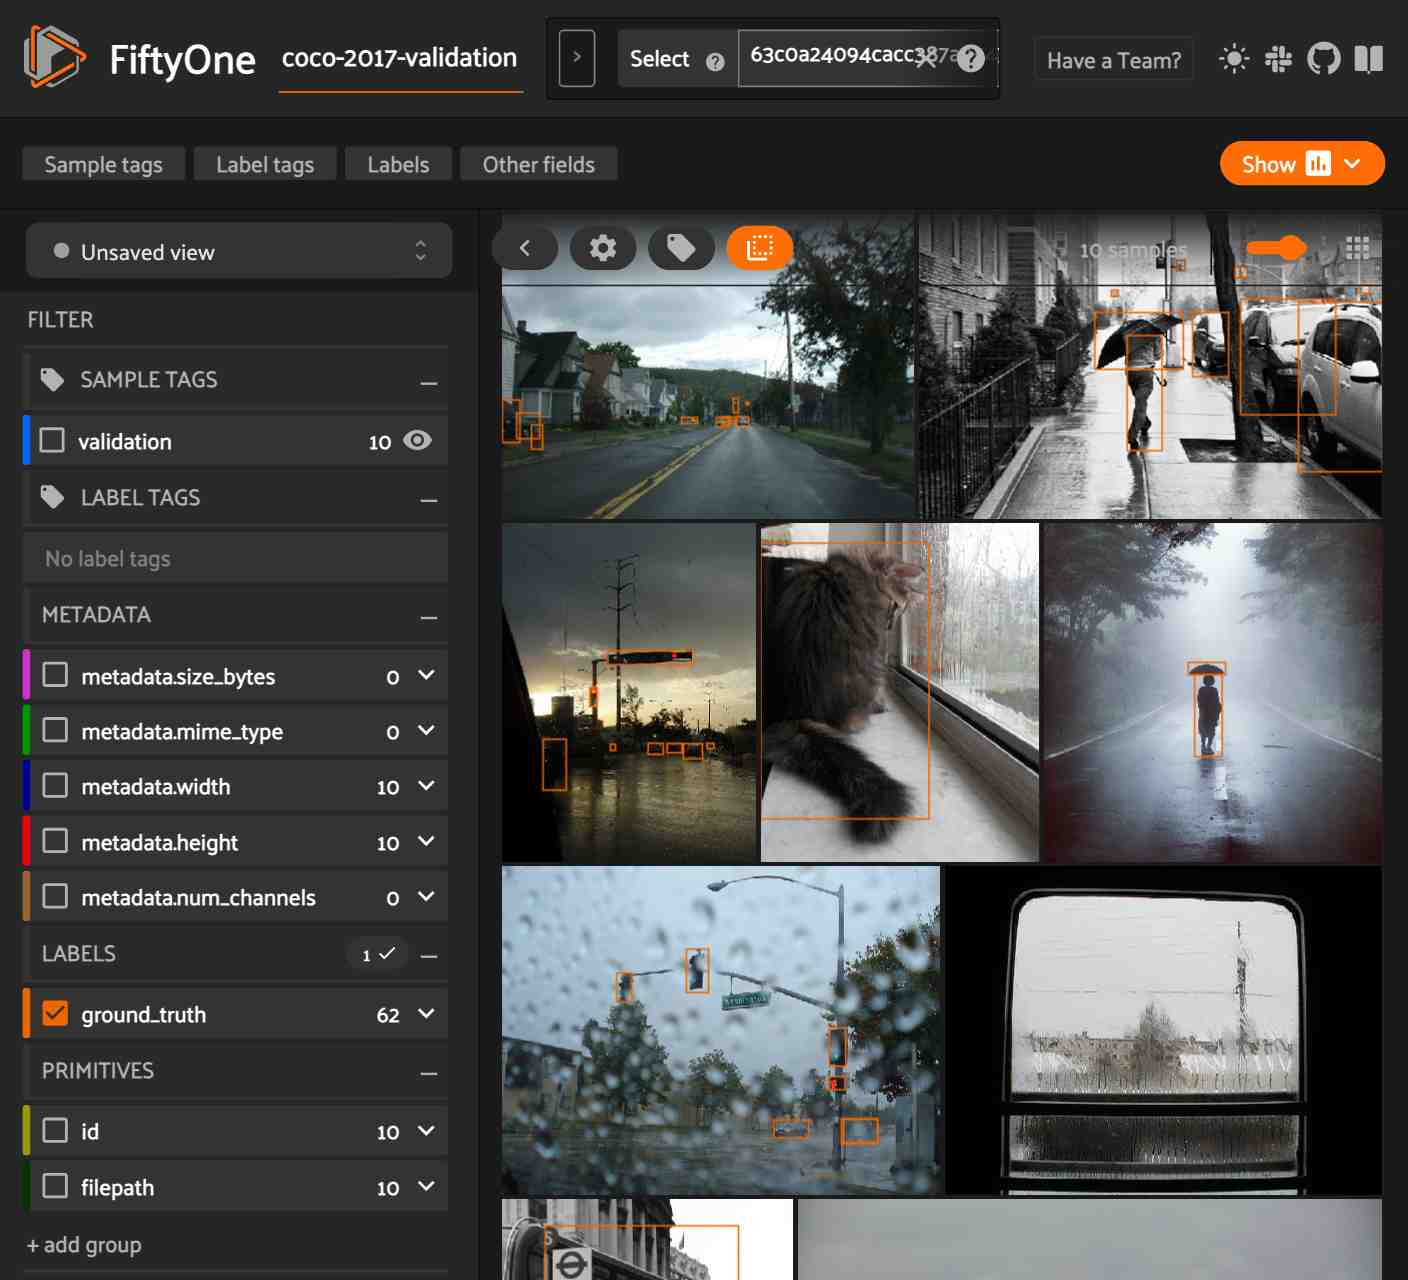

In [17]:
# get ids of gloomiest samples
top_k_ids = [res['id'] for res in top_k_samples]

# view these samples, ordered by “gloominess”
view = dataset.select(top_k_ids, ordered=True)
session.view = view

We could also query for more complicated things, like "a person holding a baseball bat":


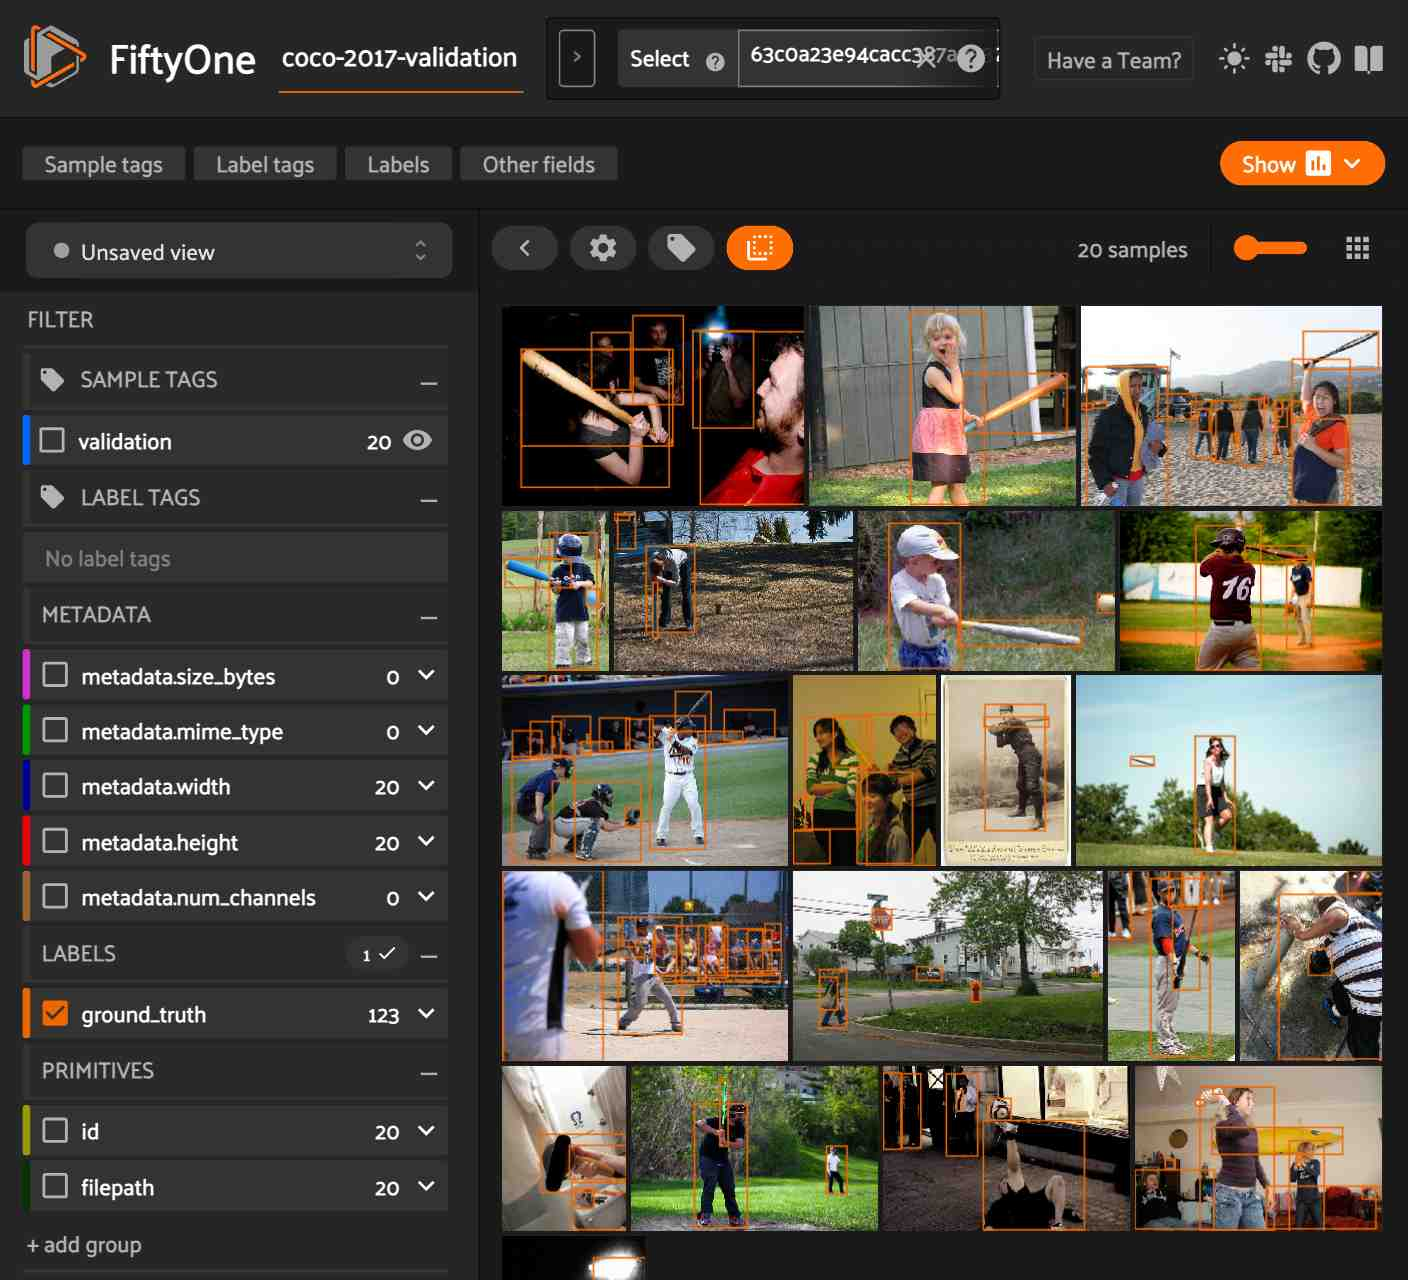

In [18]:
prompt = "a person holding a baseball bat"
query_vector = get_text_embedding(prompt, model)
top_k_samples = index.query(
    vector=query_vector,
    top_k=20,
    include_values=False
)['matches']

# get ids of samples that most resemble a person holding a baseball bat
top_k_ids = [res['id'] for res in top_k_samples]

# view these samples, ordered by similarity
view = dataset.select(top_k_ids, ordered=True)
session.view = view

While the results aren't *perfect*, it's pretty amazing that you can write an arbitrary natural language query, run it on any arbitrary dataset, and achieve this level of performance and understanding. Just take a second and think about this. The fact that we don't have to gather a dataset and train a classifier for this task is very cool, and very powerful!

Of course, it's worth noting that results from using CLIP or another foundational multi-modal ML model out of the box like this will in all likelihood not beat a classifier trained or fine-tuned on your specific data for your specific task. But that is not the point.

This is an incredible tool to use for *completely unsupervised* and *unstructured* exploration of a new dataset!

At this point, we could tag these samples in Python for [labeling or annotation](https://voxel51.com/docs/fiftyone/user_guide/annotation.html):

In [19]:
view.tag_samples("possibly holding baseball bat")

Or you can use FiftyOne's [in-App tagging features](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging).

## Putting the pieces together

Now that we have seen the full workflow for querying our data with a search vector, let's put it all together and wrap it in a function. We'll call it `sort_by_semantic_similarity()`, drawing inspiration from the [FiftyOne Brain method](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.sort_by_similarity) `sort_by_similarity()`.

Let's make it flexible enough to return either all samples, sorted by semantic similarity, or just the $k$ most similar. Note: the `top_k` argument for Pinecone queries is capped at $10000$. We'll also give an optional `score_field` argument where if `score_field!= None`, we will store the `score` values returned by the index query on the samples.

In [20]:
def sort_by_semantic_similarity(
    dataset,
    index,
    prompt,
    k=None,
    score_field=None
):
    
    query_vector = get_text_embedding(prompt, model)
    if k is not None:
        top_k=k
    else:
        top_k = int(min(10000, dataset.count()))
        
    
    result_samples = index.query(
        vector=query_vector,
        top_k=top_k,
        include_values=False
    )['matches']
    
    sample_ids = [res['id'] for res in result_samples]
    view = dataset.select(sample_ids, ordered=True)

    if score_field is not None:
        scores = [res['score'] for res in result_samples]
        dataset.add_sample_field(score_field, fo.FloatField)
        view.set_values(score_field, scores)
        dataset.save()
    
    return view

In [21]:
prompt = "a child playing with a dog"

view = sort_by_semantic_similarity(
    dataset, 
    index, 
    prompt, 
    k = 100, 
    score_field = "cosine-dist"
)

In [22]:
session.view = view

## What can you use this for?

The ability to search through your computer vision datasets with arbitrary natural language queries can be immensely useful. You can use these capabilities to [pre-annotate your data](https://voxel51.com/docs/fiftyone/tutorials/image_embeddings.html#Pre-annotation-of-samples), or tag samples to [send back to your labeling service provider](https://voxel51.com/docs/fiftyone/tutorials/cvat_annotation.html) for re-annotation. By setting a cutoff, you can also take advantage of the raw `score` values returned by the vector index query for [zero-shot image classification](https://www.pinecone.io/learn/zero-shot-image-classification-clip/), multi-output classification, or use it as a performance baseline while prototyping.

Perhaps most importantly, performing semantic image search using an off-the-shelf foundation model like CLIP can be a great way to perform ad hoc exploration of datasets in an unstructured way. You can query the data with any prompt you can possibly imagine, without the need to perform any model training or fine-tuning of any kind in order to get started. This can be useful in situations where you do not require an exhaustive or exact list of every sample that matches a given criteria. Maybe you are just interested in retrieving a few representative examples of a particular query. Or maybe you are interested in understanding the range of samples in your dataset, beyond aggregate statistics.

If you need more systematic results, you'll likely need to have the data annotated, train or fine-tune a model, or otherwise pass your data on for further processing and analysis. But using CLIP (or another multi-modal embedding model) can help you begin to bootstrap these processes!

One example of this might be in evaluating a model through visual inspection. By semantically searching your data, you might identify some problematic samples and uncover that your model seems to perform poorly in scenes with "intersections with low light". With CLIP, you can simply describe the salient characteristics of the scene in natural language and test your hypothesis (or mine new examples to add to your training set) by searching to see what other data you have that matches those characteristics.

## Conclusion

Whether you are building predictive models, looking for trends, or assessing the quality of your computer vision data, semantic search is a tool that every machine learning engineer or researcher should have in their arsenal. I hope this article has given you what you need to use this tool in your current and future computer vision workflows! 

If you want to dive deeper, here are some things for you to play around with:

* **Metrics**: cosine vs euclidean…
* **Embedding models**: CLIP is not the only one!
* **Vector search engines**: Pinecone is just one of many options
* **Prompt-crafting**: how does the phrasing of the text prompt affect the result?